In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import pyrepseq.plotting as pp

plt.style.use('bmh')

In [2]:
cpu = pd.read_csv('../data/cpu_benchmark.csv', index_col=0)
cpu = cpu[cpu['input_size']>100]
cpu.head()

,runtime,algorithm,input_size,distance
5,0.090237,kdtree,1000,1
6,0.491201,symspell,1000,1
7,0.379608,combinatorial_lookup,1000,1
8,0.302681,exhaustive_search,1000,1
9,0.121302,bktree,1000,1


In [3]:
gpu = pd.read_csv('../data/gpu_benchmark.csv', index_col=0)
gpu = gpu[gpu['input_size']>10000]
gpu.head()

,runtime,algorithm,input_size,distance
8,3.767601,symspell,30000,1
11,11.046187,symspell,100000,1
14,23.264184,symspell,300000,1
17,58.157510,symspell,1000000,1
20,168.313022,symspell,3000000,1


In [4]:
gpu['input_size'].value_counts()

30000       180
100000      180
300000      180
1000000     180
10000000    121
3000000     120
30000000     30
Name: input_size, dtype: int64

In [5]:
cpu_dist = pd.read_csv('../data/cpu_dist_benchmark.csv', index_col=0)
cpu_dist.head()

,runtime,algorithm,input_size,distance
0,6.329441,kdtree,10000,1
1,1.235529,symspell,10000,1
2,45.932961,exhaustive_search,10000,1
3,5.462839,bktree,10000,1
4,18.854132,kdtree,10000,2


In [6]:
gpu_dist = pd.read_csv('../data/gpu_dist_benchmark.csv', index_col=0)
gpu_dist.head()

,runtime,algorithm,input_size,distance
0,179.752818,symspell,100000,3
1,179.760488,symspell,100000,3
2,172.444964,symspell,100000,3
3,182.348173,symspell,100000,3
4,173.890007,symspell,100000,3


In [7]:
gpu_dist['input_size'].value_counts()

100000    390
Name: input_size, dtype: int64

In [8]:
algorithm_labels_cpu = {
                    'kdtree' : 'k-d tree bag',
                    'symspell' : 'SymDel lookup',
                    'combinatorial_lookup': 'Combinatorial lookup',
                    'exhaustive_search': 'Exhaustive search',
                    'bktree' : 'BKtree'
                   }
algorithm_labels_gpu = {
                    'symspell' : 'SymDel lookup (CPU)',
                    'V1' : 'XTNeigbor (GPU)',
                    'V2' : 'XTNeighbor-streaming (GPU)'
                   }
algorithms_cpu = ['exhaustive_search', 'bktree', 'combinatorial_lookup', 'kdtree', 'symspell']
algorithms_gpu = ['symspell', 'V1', 'V2']

cpu
gpu


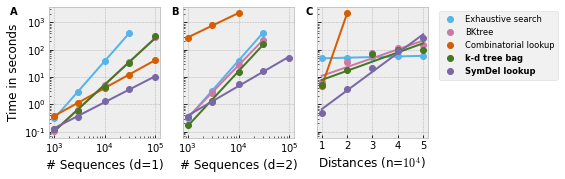

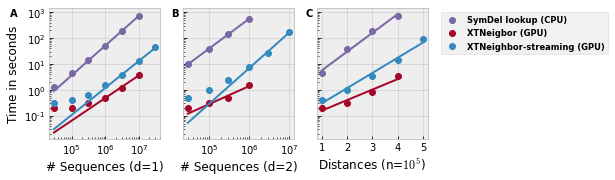

In [9]:
configs =[
    ('cpu', cpu, algorithms_cpu, cpu_dist, algorithm_labels_cpu, 'Distances (n=$10^4$)'),
    ('gpu', gpu, algorithms_gpu, gpu_dist, algorithm_labels_gpu, 'Distances (n=$10^5$)')
]

for name, df, algorithms, df2, labels, x_label in configs:
    print(name)
    fig, axes = plt.subplots(figsize=(6.8, 2.4), ncols=3, sharey=True, sharex=False)
    
    # draw left and middle graphs
    for d in [1, 2]:
        for index, algorithm in enumerate(algorithms):
            data = df[(df['distance']==d) & (df['algorithm']==algorithm)]
            mean = data.groupby('input_size').mean(numeric_only=True)
            x, y = mean.index, mean['runtime']
            if name == 'cpu':
                slope, intercept, r, p, se = scipy.stats.linregress(np.log(x), np.log(y))
                l, = axes[d-1].plot(x, y, 'o',
                        label=labels[algorithm],color=f'C{6-index}')
            elif name == 'gpu':
                slope, intercept, r, p, se = scipy.stats.linregress(np.log(x[-3:]), np.log(y[-3:]))
                l, = axes[d-1].plot(x, y, 'o', label=labels[algorithm], color=f'C{2-index}')
            axes[d-1].plot(x, np.exp(slope*np.log(x)+intercept), '-', color=l.get_color())
            axes[d-1].set_xlabel('# Sequences (d='+str(d)+')')
        axes[d-1].set_yscale('log')
        axes[d-1].set_xscale('log')
        
    # draw right graph                 
    for index, algorithm in enumerate(algorithms):
        data2 = df2[df2['algorithm']==algorithm]
        mean2 = data2.groupby('distance').mean(numeric_only=True)
        x2, y2 = mean2.index, mean2['runtime']
        if name == 'cpu':
            slope2, intercept2, r2, p, se = scipy.stats.linregress(x2, np.log(y2))
            l, = axes[2].plot(x2, y2, 'o', 
                    label=labels[algorithm], color=f'C{6-index}')
            axes[2].plot(x2, np.exp(slope2*x2+intercept2), '-', color=l.get_color())
        elif name == 'gpu':
            slope2, intercept2, r2, p, se = scipy.stats.linregress(x2, np.log(y2))
            l, = axes[2].plot(x2, y2, 'o', 
                    label=labels[algorithm], color=f'C{2-index}')
            axes[2].plot(x2, np.exp(slope2*x2+intercept2), '-', color=l.get_color())
    
    axes[2].set_xlabel(x_label)
    axes[2].set_xticks([1,2,3,4,5])    
    axes[0].set_ylabel('Time in seconds')
    legend = axes[-2].legend(bbox_to_anchor=(3.4 if name=="cpu" else 3.85, 1), fontsize='small')
    for i in range(1, 4 if name=='gpu' else 3):
        legend.get_texts()[-i].set_weight('bold') 
    axes[0].text(-0.35, 1.0, 'A', transform=axes[0].transAxes, fontweight="bold", va="top")
    axes[1].text(-0.1, 1.0, 'B', transform=axes[1].transAxes, fontweight="bold", va="top")
    axes[2].text(-0.1, 1.0, 'C', transform=axes[2].transAxes, fontweight="bold", va="top")
    
    
    fig.savefig(f'{name}_benchmark2.pdf',bbox_inches='tight')
    # fig.savefig(f'{name}_benchmark.svg')